In [1]:
import tensorflow as tf
from numba import cuda
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6

In [2]:
import os, shutil
import librosa
import numpy as np
import skimage.io
import json
import matplotlib.pyplot as plt
import joblib

In [65]:
#Training Set ONLY
#Extract .wav sounds and convert to .png spectrograms

savepath = '//'
trainpath = '//'

hop_length = 512
n_mels = 128
time_steps = 250
start_sample = 0
length_samples = time_steps*hop_length

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,n_fft=2048, hop_length=hop_length)
    #mels = numpy.log(mels + 1e-9) # add small number to avoid log(0)
    mels = librosa.power_to_db(mels, ref=np.max)
    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    skimage.io.imsave(out, img)

def process_files(directory):
    for folder in os.listdir(directory):
        endpath = os.path.join(savepath, folder)
        os.mkdir(endpath)
        inpath = os.path.join(directory, folder)
        for soundclip in os.listdir(inpath):
            endpath_file = str(endpath + '/'+soundclip[:-4]+ '.png')
            sound_orig = os.path.join(inpath, soundclip)
            y, sr = librosa.load(sound_orig, sr=22050)
            window = y[start_sample:start_sample+length_samples]
            spectrogram_image(window, sr=sr, out=endpath_file, hop_length=hop_length, n_mels=n_mels)

process_files(trainpath)

In [66]:
#Test Sets Only
#Extract all Test .wav files and convert to .png spectrograms
#Retain original folder groupings as JSON objects

savepath = '//'

hop_length = 512
n_mels = 128
time_steps = 250
start_sample = 0
length_samples = time_steps*hop_length

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,n_fft=2048, hop_length=hop_length)
    #mels = numpy.log(mels + 1e-9) # add small number to avoid log(0)
    mels = librosa.power_to_db(mels, ref=np.max)
    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    skimage.io.imsave(out, img)

def load_doc(filename):
    file=open(filename, 'r')
    text=file.read()
    file.close()
    labels = text.split()
    return labels

def process_files(directory, portion):
    label_list = {}
    for filename in os.listdir(directory):
        inpath = directory + '/' + filename
        shortname=filename[:-4]
        
        if filename.endswith('wav'):
            endpath = str(savepath + shortname + '.png')
            y, sr = librosa.load(inpath, sr=22050)
            window = y[start_sample:start_sample+length_samples]
            spectrogram_image(window, sr=sr, out=endpath, hop_length=hop_length, n_mels=n_mels)
        if filename.endswith('txt'):
            tokens = load_doc(inpath)
            label_list[shortname]=tokens
            
    js_save = str(json_path + portion + '.json')
    with open(js_save, "w") as fp:
        json.dump(label_list, fp, indent=4)
            

json_path='//'
datafiles1='//'
datafiles2='//'
datafiles3='//'
process_files(datafiles1, 'list1')
process_files(datafiles2, 'list2') 
process_files(datafiles3, 'list3')

In [67]:
#Test Files ONLY
#Optional step, convert test files into single instrument groupings

trainpath = '//'
testpath = '//'
origin = '//''

#Create folders for individual instrument data (single instrument test group)
for item in os.listdir(trainpath):
    newpath = os.path.join(testpath, item)
    if os.path.isdir(newpath):
        pass
    else:
        os.mkdir(newpath)
instruments = os.listdir(trainpath)
print(instruments)

#Move files to new single instrument test folder
def load_data(data_sources):
    single_list = {}
    for item in data_sources:
        with open(item, "r") as fp:
            data = json.load(fp)
            
        for sound in instruments:
            dest = str(testpath + sound + '/')
            for k,v in data.items():
                if len(v) == 1 and v[0] == sound:
                    filep = str(origin + k + '.png')
                    end = str(dest + k + '.png')
                    shutil.copyfile(filep, end)
                    single_list[k]=v[0]
                    
    js_save = 'single_instr_testlist.json'
    with open(js_save, "w") as fp2:
        json.dump(single_list, fp2, indent=4)

json_lists = ['list1.json','list2.json','list3.json']
load_data(json_lists)

['cla', 'cel', 'voi', 'sax', 'pia', 'flu', 'vio', 'gel', 'gac', 'tru', 'org']


# Model Component

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [120]:
#Clear memory if needed
device = cuda.get_current_device()
device.reset()

# BASE CNN MODEL

In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

In [5]:
trainset = '//'
testset = '//'

batch_size=32

train_image_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_image_gen = ImageDataGenerator(rescale=1./255)

train_images=train_image_gen.flow_from_directory(trainset, 
                                           subset='training',
                                           batch_size=batch_size, 
                                           target_size=(128,128),
                                           color_mode= 'grayscale',
                                           class_mode='categorical')

val_images=train_image_gen.flow_from_directory(trainset, 
                                         subset='validation',
                                         batch_size=batch_size, 
                                         target_size=(128,128),
                                         color_mode= 'grayscale',
                                         class_mode='categorical')


test_images=test_image_gen.flow_from_directory(testset, 
                                         batch_size=batch_size,
                                         target_size = (128,128), 
                                         color_mode= 'grayscale',
                                         class_mode='categorical')

Found 5367 images belonging to 11 classes.
Found 1338 images belonging to 11 classes.
Found 1236 images belonging to 11 classes.


In [6]:
optimiser = Adam(learning_rate=0.0001)

def base_model(input_shape):
    # build network topology
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # flatten output and feed it into dense layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    # output layer
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer=optimiser,loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
batch_size=32
trsteps=train_images.samples//batch_size
vsteps=val_images.samples//batch_size

input_shape=(128,128,1)
model=base_model(input_shape=input_shape)
history=model.fit(train_images, epochs=300, steps_per_epoch=trsteps,
                  validation_data=val_images, validation_steps=vsteps)

Epoch 1/300
167/167 [==============================] - 4s 26ms/step - loss: 2.8820 - accuracy: 0.1301 - val_loss: 2.8142 - val_accuracy: 0.1105
Epoch 2/300
167/167 [==============================] - 3s 15ms/step - loss: 2.7280 - accuracy: 0.1633 - val_loss: 2.7143 - val_accuracy: 0.1349
Epoch 3/300
167/167 [==============================] - 3s 15ms/step - loss: 2.6518 - accuracy: 0.1837 - val_loss: 2.5830 - val_accuracy: 0.2157
Epoch 4/300
167/167 [==============================] - 2s 15ms/step - loss: 2.5689 - accuracy: 0.2229 - val_loss: 2.4718 - val_accuracy: 0.3384
Epoch 5/300
167/167 [==============================] - 2s 15ms/step - loss: 2.4853 - accuracy: 0.2454 - val_loss: 2.3361 - val_accuracy: 0.3819
Epoch 6/300
167/167 [==============================] - 3s 15ms/step - loss: 2.4069 - accuracy: 0.2607 - val_loss: 2.2311 - val_accuracy: 0.4093
Epoch 7/300
167/167 [==============================] - 3s 15ms/step - loss: 2.3416 - accuracy: 0.2864 - val_loss: 2.2033 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
from keras.utils import plot_model
model.save_weights('Base_weights.h5', overwrite=True)
model.save("Base_model.h5", overwrite=True)
plot_model(model, show_shapes=True, to_file='Base_CNN.png')

In [10]:
def summarize_diagnostics(history):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label = 'test')
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label = 'test')

39/39 [==============================] - 1s 27ms/step - loss: 5.1763 - accuracy: 0.4644
> 46.440


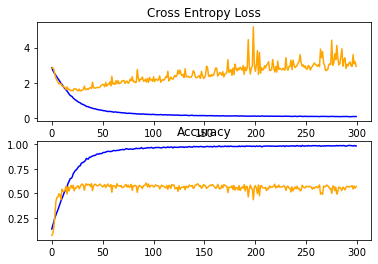

In [11]:
_, acc = model.evaluate(test_images, steps=len(test_images), verbose=1)
print('> %.3f' % (acc*100.0))
summarize_diagnostics(history)

In [13]:
from sklearn import metrics
#Base Model

testset = '//'
test_image_gen = ImageDataGenerator(rescale=1./255)
test_images=test_image_gen.flow_from_directory(testset, 
                                         batch_size=1236,
                                         target_size = (128,128), 
                                         color_mode= 'grayscale',
                                         class_mode='categorical')
X_Test,Y_Test = test_images.next()
y_hat=model.predict(X_Test)
y_hat_r=y_hat.round()
print("Base CNN with Augmentation")
print(metrics.classification_report(Y_Test, y_hat_r))

Found 1236 images belonging to 11 classes.
Base CNN with Augmentation
              precision    recall  f1-score   support

           0       0.21      0.53      0.31        17
           1       0.12      0.09      0.10        23
           2       0.28      0.20      0.23        56
           3       0.57      0.68      0.62       189
           4       0.54      0.51      0.52       216
           5       0.13      0.21      0.16        58
           6       0.84      0.49      0.62       327
           7       0.01      0.17      0.01         6
           8       0.12      0.09      0.11        11
           9       0.37      0.52      0.43        54
          10       0.71      0.37      0.48       279

   micro avg       0.48      0.46      0.47      1236
   macro avg       0.35      0.35      0.33      1236
weighted avg       0.61      0.46      0.50      1236
 samples avg       0.46      0.46      0.46      1236



/home/meeka/miniconda3/envs/language/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Image Augmentation

In [7]:
trainset = '//'
testset = '//'
batch_size=32

train_imageAug_gen = ImageDataGenerator(rescale=1./255, 
                                      rotation_range=40,
                                      brightness_range=[0.8,1.2],
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      horizontal_flip=True,
                                      validation_split=0.2)

train_images_Aug=train_imageAug_gen.flow_from_directory(trainset, 
                                           subset='training',
                                           batch_size=batch_size, 
                                           target_size=(128,128),
                                           color_mode= 'grayscale',
                                           class_mode='categorical')

val_images_Aug=train_imageAug_gen.flow_from_directory(trainset, 
                                         subset='validation',
                                         batch_size=batch_size, 
                                         target_size=(128,128),
                                         color_mode= 'grayscale',
                                         class_mode='categorical')


test_image_gen = ImageDataGenerator(rescale=1./255)
test_images=test_image_gen.flow_from_directory(testset, 
                                         batch_size=batch_size,
                                         target_size = (128,128), 
                                         color_mode= 'grayscale',
                                         class_mode='categorical')

Found 5367 images belonging to 11 classes.
Found 1338 images belonging to 11 classes.
Found 1236 images belonging to 11 classes.


In [9]:
batch_size=32
trsteps=train_images_Aug.samples//batch_size
vsteps=val_images_Aug.samples//batch_size

input_shape=(128,128,1)
model=base_model(input_shape=input_shape)
model.fit(train_images_Aug, steps_per_epoch=trsteps, epochs=1000, 
          validation_data=val_images_Aug,validation_steps=vsteps)

Epoch 1/1000
167/167 [==============================] - 8s 49ms/step - loss: 2.8991 - accuracy: 0.1052 - val_loss: 3.1832 - val_accuracy: 0.0953
Epoch 2/1000
167/167 [==============================] - 8s 49ms/step - loss: 2.7272 - accuracy: 0.1110 - val_loss: 3.4217 - val_accuracy: 0.0579
Epoch 3/1000
167/167 [==============================] - 8s 48ms/step - loss: 2.6803 - accuracy: 0.1138 - val_loss: 2.6777 - val_accuracy: 0.0998
Epoch 4/1000
167/167 [==============================] - 8s 48ms/step - loss: 2.6366 - accuracy: 0.1095 - val_loss: 2.6016 - val_accuracy: 0.1364
Epoch 5/1000
167/167 [==============================] - 8s 48ms/step - loss: 2.5966 - accuracy: 0.1288 - val_loss: 2.5329 - val_accuracy: 0.1639
Epoch 6/1000
167/167 [==============================] - 8s 48ms/step - loss: 2.5731 - accuracy: 0.1203 - val_loss: 2.5098 - val_accuracy: 0.1608
Epoch 7/1000
167/167 [==============================] - 8s 48ms/step - loss: 2.5380 - accuracy: 0.1295 - val_loss: 2.4748 - val_ac

167/167 [==============================] - 8s 48ms/step - loss: 1.6935 - accuracy: 0.4508 - val_loss: 1.4888 - val_accuracy: 0.5076
Epoch 114/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.6963 - accuracy: 0.4493 - val_loss: 1.4491 - val_accuracy: 0.5236
Epoch 115/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.6833 - accuracy: 0.4523 - val_loss: 1.4420 - val_accuracy: 0.5236
Epoch 116/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.7351 - accuracy: 0.4343 - val_loss: 1.4904 - val_accuracy: 0.4901
Epoch 117/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.6645 - accuracy: 0.4472 - val_loss: 1.4401 - val_accuracy: 0.5473
Epoch 118/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.7023 - accuracy: 0.4459 - val_loss: 1.5128 - val_accuracy: 0.5084
Epoch 119/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.6853 - accuracy: 0.4555 - val_loss: 1.5095 - val_acc

Epoch 169/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5988 - accuracy: 0.4873 - val_loss: 1.4181 - val_accuracy: 0.5145
Epoch 170/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5928 - accuracy: 0.4842 - val_loss: 1.3864 - val_accuracy: 0.5412
Epoch 171/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5788 - accuracy: 0.4888 - val_loss: 1.5137 - val_accuracy: 0.4977
Epoch 172/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5835 - accuracy: 0.4789 - val_loss: 1.7967 - val_accuracy: 0.4444
Epoch 173/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5648 - accuracy: 0.4922 - val_loss: 1.4748 - val_accuracy: 0.5168
Epoch 174/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5756 - accuracy: 0.4858 - val_loss: 1.3913 - val_accuracy: 0.5488
Epoch 175/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5900 - accuracy: 0.4879 - val_loss: 1

Epoch 225/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5201 - accuracy: 0.5053 - val_loss: 1.3305 - val_accuracy: 0.5640
Epoch 226/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4901 - accuracy: 0.5192 - val_loss: 1.3213 - val_accuracy: 0.5770
Epoch 227/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5052 - accuracy: 0.5134 - val_loss: 1.4578 - val_accuracy: 0.5221
Epoch 228/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5008 - accuracy: 0.5200 - val_loss: 1.2762 - val_accuracy: 0.5854
Epoch 229/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5347 - accuracy: 0.4992 - val_loss: 1.2608 - val_accuracy: 0.5884
Epoch 230/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5010 - accuracy: 0.5179 - val_loss: 1.4342 - val_accuracy: 0.5442
Epoch 231/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.5001 - accuracy: 0.5211 - val_loss: 1

Epoch 281/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4759 - accuracy: 0.5237 - val_loss: 1.3620 - val_accuracy: 0.5625
Epoch 282/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4821 - accuracy: 0.5218 - val_loss: 1.5269 - val_accuracy: 0.4939
Epoch 283/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4424 - accuracy: 0.5378 - val_loss: 1.4070 - val_accuracy: 0.5335
Epoch 284/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4663 - accuracy: 0.5260 - val_loss: 1.2037 - val_accuracy: 0.6098
Epoch 285/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4607 - accuracy: 0.5348 - val_loss: 1.6584 - val_accuracy: 0.4733
Epoch 286/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4405 - accuracy: 0.5316 - val_loss: 1.2070 - val_accuracy: 0.5945
Epoch 287/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4569 - accuracy: 0.5376 - val_loss: 1

Epoch 337/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4061 - accuracy: 0.5458 - val_loss: 1.3417 - val_accuracy: 0.5587
Epoch 338/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4062 - accuracy: 0.5470 - val_loss: 1.2532 - val_accuracy: 0.5823
Epoch 339/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4288 - accuracy: 0.5361 - val_loss: 1.2508 - val_accuracy: 0.5938
Epoch 340/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4065 - accuracy: 0.5408 - val_loss: 1.2536 - val_accuracy: 0.5915
Epoch 341/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4084 - accuracy: 0.5488 - val_loss: 1.2563 - val_accuracy: 0.5755
Epoch 342/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4090 - accuracy: 0.5455 - val_loss: 1.2694 - val_accuracy: 0.5945
Epoch 343/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3998 - accuracy: 0.5453 - val_loss: 1

Epoch 393/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3655 - accuracy: 0.5629 - val_loss: 1.2609 - val_accuracy: 0.6021
Epoch 394/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3674 - accuracy: 0.5687 - val_loss: 1.1719 - val_accuracy: 0.6136
Epoch 395/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3944 - accuracy: 0.5550 - val_loss: 1.3027 - val_accuracy: 0.5770
Epoch 396/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3874 - accuracy: 0.5505 - val_loss: 1.2212 - val_accuracy: 0.6014
Epoch 397/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.4002 - accuracy: 0.5629 - val_loss: 1.3574 - val_accuracy: 0.5495
Epoch 398/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3677 - accuracy: 0.5683 - val_loss: 1.3092 - val_accuracy: 0.5595
Epoch 399/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3596 - accuracy: 0.5709 - val_loss: 1

Epoch 449/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3180 - accuracy: 0.5754 - val_loss: 1.1677 - val_accuracy: 0.6159
Epoch 450/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3516 - accuracy: 0.5588 - val_loss: 1.3955 - val_accuracy: 0.5473
Epoch 451/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3523 - accuracy: 0.5590 - val_loss: 1.1754 - val_accuracy: 0.6166
Epoch 452/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3357 - accuracy: 0.5760 - val_loss: 1.1605 - val_accuracy: 0.6220
Epoch 453/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3399 - accuracy: 0.5694 - val_loss: 1.2482 - val_accuracy: 0.6006
Epoch 454/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3822 - accuracy: 0.5649 - val_loss: 1.1597 - val_accuracy: 0.6334
Epoch 455/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3281 - accuracy: 0.5674 - val_loss: 1

Epoch 505/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3099 - accuracy: 0.5756 - val_loss: 1.2719 - val_accuracy: 0.5899
Epoch 506/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3375 - accuracy: 0.5576 - val_loss: 1.1209 - val_accuracy: 0.6212
Epoch 507/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3294 - accuracy: 0.5783 - val_loss: 1.2505 - val_accuracy: 0.5846
Epoch 508/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3204 - accuracy: 0.5783 - val_loss: 1.1319 - val_accuracy: 0.6319
Epoch 509/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2930 - accuracy: 0.5927 - val_loss: 1.1467 - val_accuracy: 0.6159
Epoch 510/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3402 - accuracy: 0.5711 - val_loss: 1.2094 - val_accuracy: 0.5899
Epoch 511/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3129 - accuracy: 0.5814 - val_loss: 1

Epoch 561/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2731 - accuracy: 0.5867 - val_loss: 1.0756 - val_accuracy: 0.6524
Epoch 562/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2877 - accuracy: 0.5803 - val_loss: 1.2338 - val_accuracy: 0.6006
Epoch 563/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2708 - accuracy: 0.5916 - val_loss: 1.2203 - val_accuracy: 0.6029
Epoch 564/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.3108 - accuracy: 0.5858 - val_loss: 1.1419 - val_accuracy: 0.6128
Epoch 565/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2972 - accuracy: 0.5919 - val_loss: 1.0700 - val_accuracy: 0.6494
Epoch 566/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2852 - accuracy: 0.5833 - val_loss: 1.2704 - val_accuracy: 0.5899
Epoch 567/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2856 - accuracy: 0.5805 - val_loss: 1

Epoch 617/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2719 - accuracy: 0.5953 - val_loss: 2.0226 - val_accuracy: 0.4573
Epoch 618/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2808 - accuracy: 0.5925 - val_loss: 1.2382 - val_accuracy: 0.5823
Epoch 619/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2741 - accuracy: 0.5801 - val_loss: 1.1260 - val_accuracy: 0.6425
Epoch 620/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2644 - accuracy: 0.5903 - val_loss: 1.1884 - val_accuracy: 0.6197
Epoch 621/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2948 - accuracy: 0.5846 - val_loss: 1.2639 - val_accuracy: 0.5816
Epoch 622/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2680 - accuracy: 0.5934 - val_loss: 1.0818 - val_accuracy: 0.6456
Epoch 623/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2714 - accuracy: 0.5970 - val_loss: 1

Epoch 673/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2477 - accuracy: 0.6040 - val_loss: 1.3302 - val_accuracy: 0.5846
Epoch 674/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2704 - accuracy: 0.5865 - val_loss: 1.1502 - val_accuracy: 0.6159
Epoch 675/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2763 - accuracy: 0.5880 - val_loss: 1.1850 - val_accuracy: 0.6098
Epoch 676/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2456 - accuracy: 0.6009 - val_loss: 1.1042 - val_accuracy: 0.6364
Epoch 677/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2547 - accuracy: 0.5991 - val_loss: 1.2356 - val_accuracy: 0.5892
Epoch 678/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2561 - accuracy: 0.5948 - val_loss: 1.0862 - val_accuracy: 0.6502
Epoch 679/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2263 - accuracy: 0.6096 - val_loss: 1

Epoch 729/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2446 - accuracy: 0.6004 - val_loss: 1.1017 - val_accuracy: 0.6220
Epoch 730/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2563 - accuracy: 0.5923 - val_loss: 1.1211 - val_accuracy: 0.6448
Epoch 731/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2361 - accuracy: 0.6015 - val_loss: 1.0987 - val_accuracy: 0.6418
Epoch 732/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2296 - accuracy: 0.5979 - val_loss: 1.0613 - val_accuracy: 0.6524
Epoch 733/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2494 - accuracy: 0.6011 - val_loss: 1.4361 - val_accuracy: 0.5381
Epoch 734/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2530 - accuracy: 0.5996 - val_loss: 1.1593 - val_accuracy: 0.6258
Epoch 735/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2566 - accuracy: 0.5925 - val_loss: 1

Epoch 785/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2474 - accuracy: 0.5996 - val_loss: 1.0862 - val_accuracy: 0.6448
Epoch 786/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2197 - accuracy: 0.6152 - val_loss: 1.1094 - val_accuracy: 0.6349
Epoch 787/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2288 - accuracy: 0.6112 - val_loss: 1.1805 - val_accuracy: 0.6250
Epoch 788/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2516 - accuracy: 0.5989 - val_loss: 1.0888 - val_accuracy: 0.6441
Epoch 789/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2241 - accuracy: 0.6054 - val_loss: 1.1342 - val_accuracy: 0.6273
Epoch 790/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2117 - accuracy: 0.6052 - val_loss: 1.1785 - val_accuracy: 0.6273
Epoch 791/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2197 - accuracy: 0.6015 - val_loss: 1

Epoch 841/1000
167/167 [==============================] - 8s 49ms/step - loss: 1.1944 - accuracy: 0.6155 - val_loss: 1.0801 - val_accuracy: 0.6433
Epoch 842/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2093 - accuracy: 0.6099 - val_loss: 1.1650 - val_accuracy: 0.6113
Epoch 843/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2092 - accuracy: 0.6114 - val_loss: 1.2037 - val_accuracy: 0.6037
Epoch 844/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1955 - accuracy: 0.6088 - val_loss: 1.1493 - val_accuracy: 0.6136
Epoch 845/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2149 - accuracy: 0.6069 - val_loss: 1.1035 - val_accuracy: 0.6311
Epoch 846/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2054 - accuracy: 0.6112 - val_loss: 1.0803 - val_accuracy: 0.6570
Epoch 847/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2130 - accuracy: 0.6129 - val_loss: 1

Epoch 897/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1898 - accuracy: 0.6174 - val_loss: 1.3068 - val_accuracy: 0.5831
Epoch 898/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1807 - accuracy: 0.6236 - val_loss: 1.1427 - val_accuracy: 0.6273
Epoch 899/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1865 - accuracy: 0.6186 - val_loss: 1.2092 - val_accuracy: 0.6166
Epoch 900/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1984 - accuracy: 0.6086 - val_loss: 1.0616 - val_accuracy: 0.6441
Epoch 901/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2087 - accuracy: 0.6182 - val_loss: 1.0672 - val_accuracy: 0.6570
Epoch 902/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.2031 - accuracy: 0.6187 - val_loss: 1.0401 - val_accuracy: 0.6578
Epoch 903/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1902 - accuracy: 0.6208 - val_loss: 1

Epoch 953/1000
167/167 [==============================] - 8s 49ms/step - loss: 1.1735 - accuracy: 0.6199 - val_loss: 1.3655 - val_accuracy: 0.5518
Epoch 954/1000
167/167 [==============================] - 8s 49ms/step - loss: 1.1883 - accuracy: 0.6116 - val_loss: 1.1127 - val_accuracy: 0.6380
Epoch 955/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1882 - accuracy: 0.6073 - val_loss: 1.2059 - val_accuracy: 0.6067
Epoch 956/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1802 - accuracy: 0.6163 - val_loss: 1.2361 - val_accuracy: 0.5998
Epoch 957/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1859 - accuracy: 0.6227 - val_loss: 1.0838 - val_accuracy: 0.6380
Epoch 958/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1673 - accuracy: 0.6225 - val_loss: 1.0834 - val_accuracy: 0.6402
Epoch 959/1000
167/167 [==============================] - 8s 48ms/step - loss: 1.1829 - accuracy: 0.6219 - val_loss: 1

In [ ]:
from keras.utils import plot_model
model.save_weights('Base_wAug_weights.h5', overwrite=True)
model.save("Base_wAug_model.h5", overwrite=True)
plot_model(model, show_shapes=True, to_file='Base_wAug_CNN.png')

In [15]:
_, acc = model.evaluate(test_images, steps=len(test_images), verbose=1)
print('> %.3f' % (acc*100.0))
#summarize_diagnostics(model)

39/39 [==============================] - 1s 16ms/step - loss: 4.7167 - accuracy: 0.4757
> 47.573


In [16]:
from sklearn import metrics
testset = '//'
test_image_gen = ImageDataGenerator(rescale=1./255)
test_images=test_image_gen.flow_from_directory(testset, 
                                         batch_size=1236,
                                         target_size = (128,128), 
                                         color_mode= 'grayscale',
                                         class_mode='categorical')
X_Test,Y_Test = test_images.next()
y_hat=model.predict(X_Test)
y_hat_r=y_hat.round()
print("Base CNN with Augmentation")
print(metrics.classification_report(Y_Test, y_hat_r))

Found 1236 images belonging to 11 classes.
Base CNN with Augmentation
              precision    recall  f1-score   support

           0       0.16      0.47      0.24        17
           1       0.00      0.00      0.00        23
           2       1.00      0.04      0.07        56
           3       0.83      0.57      0.68       189
           4       0.30      0.89      0.45       216
           5       0.50      0.09      0.15        58
           6       0.88      0.67      0.76       327
           7       0.07      0.33      0.12         6
           8       0.10      0.09      0.10        11
           9       1.00      0.20      0.34        54
          10       0.64      0.05      0.09       279

   micro avg       0.49      0.45      0.47      1236
   macro avg       0.50      0.31      0.27      1236
weighted avg       0.67      0.45      0.43      1236
 samples avg       0.45      0.45      0.45      1236



/home/meeka/miniconda3/envs/language/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meeka/miniconda3/envs/language/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Inception 

In [5]:
#Inception IMPROVED
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers.merge import concatenate

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    #1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation= 'relu')(layer_in)
    #3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    #5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    #3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    #concatenate filters
    layer_out=concatenate([conv1, conv3, conv5, pool], axis=-1)
    layer_out=Flatten()(layer_out)
    layer_out=Dense(11, activation='softmax')(layer_out)
    return layer_out
    
visible = Input(shape=(128,128,1))
#layer=inception_module(visible, 64,128,32)
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
model=Model(inputs=visible, outputs=layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 96) 192         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 16) 32          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 1)  0           input_1[0][0]                    
______________________________________________________________________________________________

In [8]:
batch_size=32
trsteps=train_images_Aug.samples//batch_size
vsteps=val_images_Aug.samples//batch_size
optimiser = Adam(learning_rate=0.001)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images_Aug, epochs=5, steps_per_epoch=trsteps,
          validation_data=val_images_Aug, validation_steps=vsteps)

Epoch 1/5
167/167 [==============================] - 22s 131ms/step - loss: 4.2903 - accuracy: 0.1121 - val_loss: 2.4209 - val_accuracy: 0.1014
Epoch 2/5
167/167 [==============================] - 22s 132ms/step - loss: 2.8295 - accuracy: 0.1419 - val_loss: 2.7945 - val_accuracy: 0.1418
Epoch 3/5
167/167 [==============================] - 22s 129ms/step - loss: 2.6394 - accuracy: 0.1670 - val_loss: 2.6901 - val_accuracy: 0.1753
Epoch 4/5
167/167 [==============================] - 22s 132ms/step - loss: 2.7038 - accuracy: 0.1640 - val_loss: 2.4024 - val_accuracy: 0.2134
Epoch 5/5
167/167 [==============================] - 22s 131ms/step - loss: 2.6436 - accuracy: 0.1640 - val_loss: 2.2465 - val_accuracy: 0.2470


In [ ]:
model.save_weights('Inception_weights.h5', overwrite=True)
model.save("Inception_model.h5", overwrite=True)
plot_model(model, show_shapes=True, to_file='Inception.png')

78/78 [==============================] - 1s 13ms/step - loss: 2.3709 - accuracy: 0.2241
> 22.411


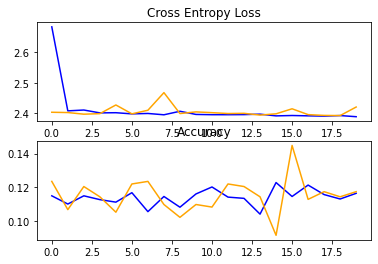

In [50]:
_, acc = model.evaluate(test_images, steps=len(test_images), verbose=1)
print('> %.3f' % (acc*100.0))
summarize_diagnostics(history)

In [3]:
#Load Model Weights for Scoring

from keras.models import load_model
model = load_model('InceptionModelAug.h5')
inception_weights=model.load_weights('inceptionAug.h5')

In [46]:
from sklearn import metrics
testset = '//'
test_image_gen = ImageDataGenerator(rescale=1./255)
test_images=test_image_gen.flow_from_directory(testset, 
                                         batch_size=1236,
                                         target_size = (128,128), 
                                         color_mode= 'grayscale',
                                         class_mode='categorical')
X_Test,Y_Test = test_images.next()
y_hat=model.predict(X_Test)
y_hat_r=y_hat.round()

y_hat=model.predict(X_Test)
y_hat_r=y_hat.round()
print("Overall Inception no Augmentation")
print(metrics.classification_report(Y_Test, y_hat_r))

              precision    recall  f1-score   support

           0       0.29      0.24      0.26        17
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        56
           3       0.43      0.31      0.36       189
           4       0.34      0.41      0.37       216
           5       0.03      0.09      0.04        58
           6       0.00      0.00      0.00       327
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        11
           9       0.14      0.22      0.17        54
          10       0.55      0.18      0.27       279

   micro avg       0.27      0.18      0.21      1236
   macro avg       0.16      0.13      0.13      1236
weighted avg       0.26      0.18      0.20      1236
 samples avg       0.18      0.18      0.18      1236



In [ ]:
#Re-run with augmented Images

batch_size=32
trsteps=train_images.samples//batch_size
vsteps=val_images.samples//batch_size
optimiser = Adam(learning_rate=0.0001)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images_Aug, steps_per_epoch=trsteps, epochs=10, 
          validation_data=val_images_Aug,validation_steps=vsteps)

In [7]:
#Inception with Augmented Images
#Load Model Weights for Scoring

from sklearn import metrics
from keras.models import load_model

model = load_model('InceptionModelAug.h5')
inception_weights=model.load_weights('inceptionAug.h5')

y_hat=model.predict(X_Test)
y_hat_r=y_hat.round()
print(metrics.classification_report(Y_Test, y_hat_r))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        56
           3       0.60      0.08      0.14       189
           4       0.48      0.32      0.38       216
           5       0.05      0.17      0.08        58
           6       0.95      0.06      0.11       327
           7       0.00      0.00      0.00         6
           8       0.02      0.18      0.03        11
           9       0.00      0.00      0.00        54
          10       0.45      0.29      0.35       279

   micro avg       0.24      0.16      0.19      1236
   macro avg       0.23      0.10      0.10      1236
weighted avg       0.53      0.16      0.20      1236
 samples avg       0.16      0.16      0.16      1236



/home/meeka/miniconda3/envs/language/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meeka/miniconda3/envs/language/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Boltzmann PreProcessing

number of samples:  6705
keys:  ['label', 'filename', 'data']
image shape:  (128, 128)
labels: ['cel' 'cla' 'flu' 'gac' 'gel' 'org' 'pia' 'sax' 'tru' 'vio' 'voi']


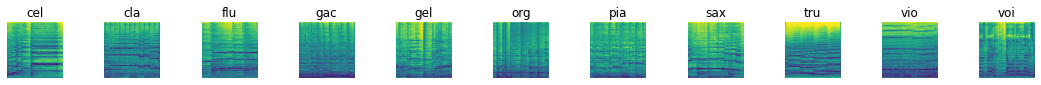

In [82]:
#import image files and save as pickle file

from collections import Counter
%matplotlib inline
import joblib
from skimage.io import imread
from skimage.transform import resize
 
src='//'
    
def resize_all(src, pklname, width=128, height=128):     
    height = height if height is not None else width
    data = dict()
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    for subdir in os.listdir(src):
        current_path = os.path.join(src, subdir)
        for file in os.listdir(current_path):
            if file[-3:] in {'jpg', 'png'}:
                im = imread(os.path.join(current_path, file))
                im = resize(im, (width, height))
                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im)
        joblib.dump(data, pklname)
    
resize_all(src, 'trainset')
 
data = joblib.load('trainset_128x128px.pkl')
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
Counter(data['label'])

# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

Found 6705 images belonging to 11 classes.


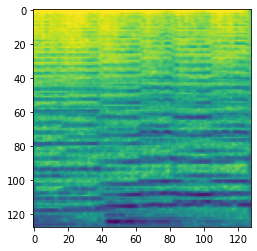

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

trainset = '//'
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(trainset, 
                                                    target_size=(128, 128), 
                                                    batch_size=6705,
                                                    shuffle=False,
                                                    color_mode= 'grayscale',
                                                    class_mode='categorical')

X_Tr,Y_Tr = train_generator.next()
plt.figure()
imgplot=plt.imshow(image.array_to_img(X_Tr[0]))
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
from sklearn import  metrics
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
%matplotlib inline

X = X_Tr.reshape(len(X_Tr),-1)
X = np.asarray(X, 'float32')
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)
y = np.argmax(Y_Tr, axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, shuffle=True,random_state=33)


def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=1024))
    model.add(Activation('relu'))
    #model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(11))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

rbm = BernoulliRBM(n_components=1024, learning_rate=0.001, n_iter=100, random_state=33, verbose=True)   
clf = KerasClassifier(build_fn=create_model, epochs=1000, verbose=1)
classifier = Pipeline(steps=[('rbm', rbm), ('NN', clf)])
classifier.fit(X_train, Y_train) 

[BernoulliRBM] Iteration 1, pseudo-likelihood = -11080.99, time = 240.63s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -11033.32, time = 243.08s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -11064.90, time = 242.81s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -11031.63, time = 242.25s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -10967.13, time = 242.61s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -10939.43, time = 242.71s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -10980.69, time = 243.04s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -10875.83, time = 243.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -10935.83, time = 242.98s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -10869.24, time = 242.48s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -10937.34, time = 242.26s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -10895.71, time = 242.12s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -10946.51, time = 242.24s
[BernoulliRBM] Iteration 14, pseud

189/189 [==============================] - 1s 3ms/step - loss: 0.8628 - accuracy: 0.6869
Epoch 87/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8603 - accuracy: 0.6853
Epoch 88/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8468 - accuracy: 0.6929
Epoch 89/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8474 - accuracy: 0.6899
Epoch 90/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8638 - accuracy: 0.6843
Epoch 91/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8376 - accuracy: 0.6997
Epoch 92/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8351 - accuracy: 0.6934
Epoch 93/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8135 - accuracy: 0.7083
Epoch 94/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8325 - accuracy: 0.6908
Epoch 95/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.8142 - a

189/189 [==============================] - 1s 3ms/step - loss: 0.6197 - accuracy: 0.7668
Epoch 166/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.6318 - accuracy: 0.7585
Epoch 167/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.6157 - accuracy: 0.7638
Epoch 168/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.6137 - accuracy: 0.7680
Epoch 169/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.6132 - accuracy: 0.7635
Epoch 170/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.6136 - accuracy: 0.7690
Epoch 171/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.6120 - accuracy: 0.7691
Epoch 172/1000
189/189 [==============================] - 0s 2ms/step - loss: 0.6178 - accuracy: 0.7623
Epoch 173/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.6239 - accuracy: 0.7595
Epoch 174/1000
189/189 [==============================] - 1s 3ms/step - loss: 0

189/189 [==============================] - 1s 3ms/step - loss: 0.4456 - accuracy: 0.8184
Epoch 322/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4628 - accuracy: 0.8208
Epoch 323/1000
189/189 [==============================] - 0s 3ms/step - loss: 0.4405 - accuracy: 0.8190
Epoch 324/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4467 - accuracy: 0.8212
Epoch 325/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4601 - accuracy: 0.8081
Epoch 326/1000
189/189 [==============================] - 0s 2ms/step - loss: 0.4615 - accuracy: 0.8097
Epoch 327/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4375 - accuracy: 0.8200
Epoch 328/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4525 - accuracy: 0.8137
Epoch 329/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4471 - accuracy: 0.8223
Epoch 330/1000
189/189 [==============================] - 0s 3ms/step - loss: 0

189/189 [==============================] - 0s 2ms/step - loss: 0.3878 - accuracy: 0.8422
Epoch 478/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3831 - accuracy: 0.8449
Epoch 479/1000
189/189 [==============================] - 0s 2ms/step - loss: 0.3879 - accuracy: 0.8376
Epoch 480/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3979 - accuracy: 0.8366
Epoch 481/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4017 - accuracy: 0.8318
Epoch 482/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3779 - accuracy: 0.8381
Epoch 483/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8306
Epoch 484/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3895 - accuracy: 0.8356
Epoch 485/1000
189/189 [==============================] - 0s 2ms/step - loss: 0.3938 - accuracy: 0.8378
Epoch 486/1000
189/189 [==============================] - 1s 3ms/step - loss: 0

189/189 [==============================] - 0s 2ms/step - loss: 0.3545 - accuracy: 0.8523
Epoch 634/1000
189/189 [==============================] - 0s 3ms/step - loss: 0.3560 - accuracy: 0.8517
Epoch 635/1000
189/189 [==============================] - 0s 3ms/step - loss: 0.3557 - accuracy: 0.8497
Epoch 636/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3583 - accuracy: 0.8523
Epoch 637/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3684 - accuracy: 0.8490
Epoch 638/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3631 - accuracy: 0.8494
Epoch 639/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3555 - accuracy: 0.8581
Epoch 640/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3629 - accuracy: 0.8495
Epoch 641/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3624 - accuracy: 0.8507
Epoch 642/1000
189/189 [==============================] - 1s 3ms/step - loss: 0

189/189 [==============================] - 1s 3ms/step - loss: 0.3275 - accuracy: 0.8619
Epoch 790/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3284 - accuracy: 0.8649
Epoch 791/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3248 - accuracy: 0.8618
Epoch 792/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3303 - accuracy: 0.8593
Epoch 793/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3429 - accuracy: 0.8619
Epoch 794/1000
189/189 [==============================] - 0s 2ms/step - loss: 0.3477 - accuracy: 0.8590
Epoch 795/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3306 - accuracy: 0.8626
Epoch 796/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3209 - accuracy: 0.8697
Epoch 797/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3271 - accuracy: 0.8663
Epoch 798/1000
189/189 [==============================] - 1s 3ms/step - loss: 0

189/189 [==============================] - 1s 3ms/step - loss: 0.3185 - accuracy: 0.8661
Epoch 946/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3128 - accuracy: 0.8706
Epoch 947/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3028 - accuracy: 0.8762
Epoch 948/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3119 - accuracy: 0.8722
Epoch 949/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3115 - accuracy: 0.8653
Epoch 950/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3156 - accuracy: 0.8719
Epoch 951/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3093 - accuracy: 0.8722
Epoch 952/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3069 - accuracy: 0.8731
Epoch 953/1000
189/189 [==============================] - 1s 3ms/step - loss: 0.3042 - accuracy: 0.8739
Epoch 954/1000
189/189 [==============================] - 1s 3ms/step - loss: 0

Pipeline(steps=[('rbm',
                 BernoulliRBM(learning_rate=0.001, n_components=1024,
                              n_iter=100, random_state=33, verbose=True)),
                ('NN',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f468f0fbd10>)])

In [10]:
#Extract Clean Test set for scoring

testset = '//'
test_image_gen = ImageDataGenerator(rescale=1./255)
test_images=test_image_gen.flow_from_directory(testset, 
                                         batch_size=1236,
                                         target_size = (128,128), 
                                         color_mode= 'grayscale',
                                         class_mode='categorical')

X_Test,Y_Test = test_images.next()

Found 1236 images belonging to 11 classes.


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
39/39 [==============================] - 0s 989us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.06      0.09      0.07        23
           2       0.00      0.00      0.00        56
           3       0.32      0.08      0.13       189
           4       0.52      0.40      0.45       216
           5       0.11      0.17      0.14        58
           6       0.56      0.46      0.50       327
           7       0.01      0.33      0.02         6
           8       0.03      0.64      0.05        11
           9       0.08      0.09      0.09        54
          10    

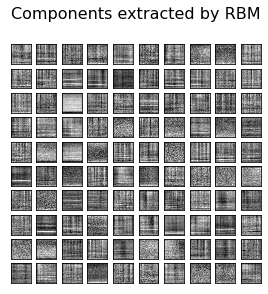

In [11]:
XT = X_Test.reshape(len(X_Test),-1)
XT = np.asarray(XT, 'float32')
XT = (XT - np.min(XT, 0)) / (np.max(X, 0) + 0.0001)
YT = np.argmax(Y_Test, axis=1)

y_hat = classifier.predict(XT)
y_hat_r=y_hat.round()
print(metrics.classification_report(YT, y_hat_r))

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_[:100]):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape((128, 128)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
39/39 [==============================] - 0s 989us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.06      0.09      0.07        23
           2       0.00      0.00      0.00        56
           3       0.32      0.08      0.13       189
           4       0.52      0.40      0.45       216
           5       0.11      0.17      0.14        58
           6       0.56      0.46      0.50       327
           7       0.01      0.33      0.02         6
           8       0.03      0.64      0.05        11
           9       0.08      0.09      0.09        54
          10    

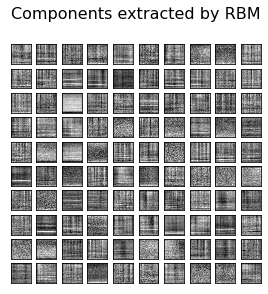

In [11]:
XT = X_Test.reshape(len(X_Test),-1)
XT = np.asarray(XT, 'float32')
XT = (XT - np.min(XT, 0)) / (np.max(X, 0) + 0.0001)
YT = np.argmax(Y_Test, axis=1)

y_hat = classifier.predict(XT)
y_hat_r=y_hat.round()
print(metrics.classification_report(YT, y_hat_r))

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_[:100]):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape((128, 128)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

In [12]:
print(metrics.classification_report(YT, y_hat_r))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.06      0.09      0.07        23
           2       0.00      0.00      0.00        56
           3       0.32      0.08      0.13       189
           4       0.52      0.40      0.45       216
           5       0.11      0.17      0.14        58
           6       0.56      0.46      0.50       327
           7       0.01      0.33      0.02         6
           8       0.03      0.64      0.05        11
           9       0.08      0.09      0.09        54
          10       0.51      0.06      0.11       279

    accuracy                           0.24      1236
   macro avg       0.20      0.21      0.14      1236
weighted avg       0.41      0.24      0.27      1236



In [35]:
import pandas as pd
merged=zip(y_hat,YT)
predictions=pd.DataFrame(merged,columns=['predictions', 'actual'])
predictions.to_csv('Boltzmann_results.csv')

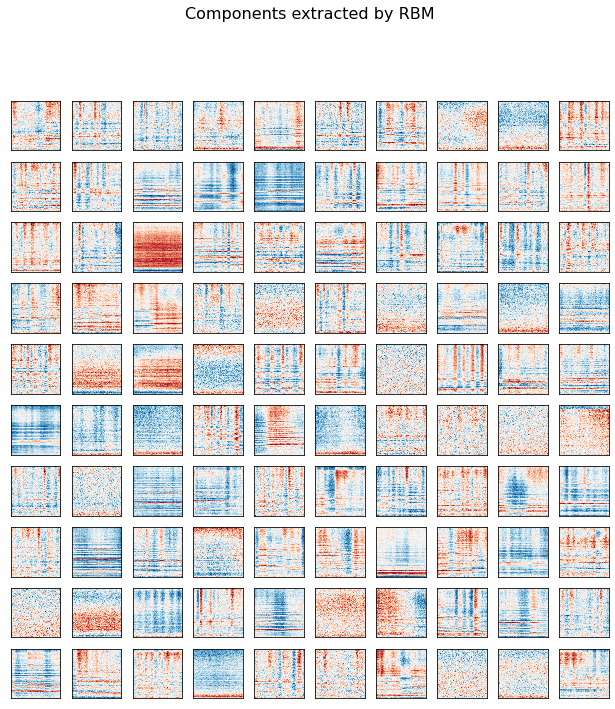

In [13]:
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_[:100]):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape((128, 128)), cmap=plt.cm.RdBu, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()



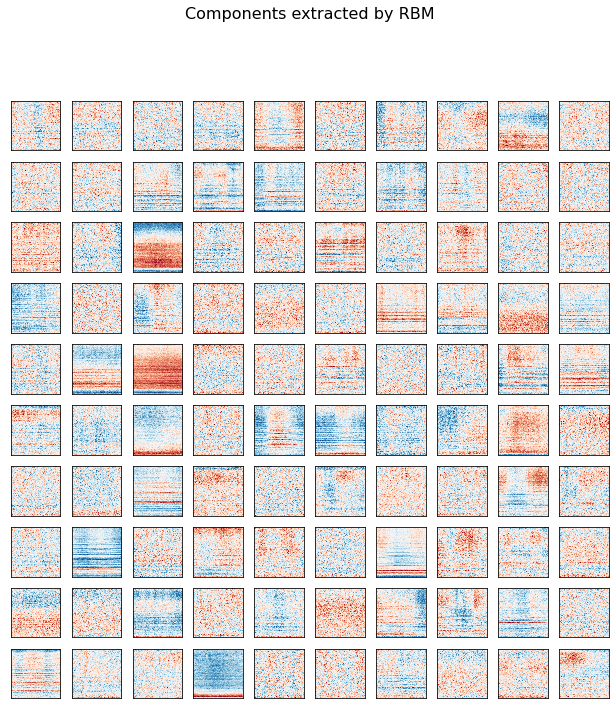

In [12]:
#50 training cases

plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_[:100]):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape((128, 128)), cmap=plt.cm.RdBu, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()
